In [1]:
import copy
import os

import matplotlib.pyplot as plt
import numpy as np
import scipy
from tqdm import tqdm
import pickle

from complex_network.materials.dielectric import Dielectric
from complex_network.networks import network_factory, pole_calculator
from complex_network.networks.network_perturbator import NetworkPerturbator
from complex_network.networks.network_spec import NetworkSpec

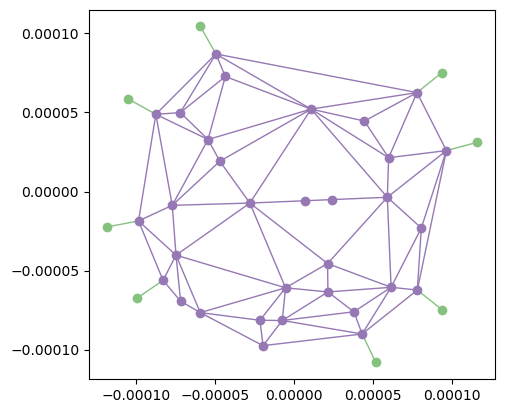

In [2]:
# Network
np.random.seed(6)
spec = NetworkSpec(
    network_type="delaunay",
    network_shape="circular",
    num_seed_nodes=0,
    num_internal_nodes=30,
    num_external_nodes=8,
    network_size=100e-6,
    external_size=120e-6,
    external_offset=0.0,
    node_S_mat_type="COE",
    node_S_mat_params={},
    material=Dielectric("glass"),
)

network = network_factory.generate_network(spec)
network.translate_node(27, np.array([-4e-6, 0.0]))
network.add_segment_to_link(38, [0.4, 0.6])
network.draw(equal_aspect=True)

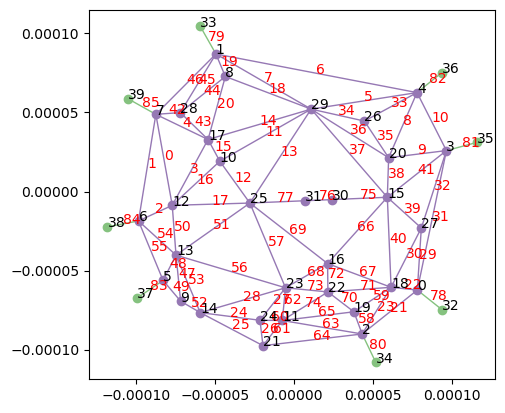

In [3]:
network.draw(equal_aspect=True, show_indices=True)

In [4]:
# Network size based on internal nodes
min_x = np.min([node.position[0] for node in network.internal_nodes])
max_x = np.max([node.position[0] for node in network.internal_nodes])
min_y = np.min([node.position[1] for node in network.internal_nodes])
max_y = np.max([node.position[1] for node in network.internal_nodes])

width = max_x - min_x
height = max_y - min_y
print(f"Network width: {width/(1e-6):.2f}um")
print(f"Network height: {height/(1e-6):.2f}um")

# Mean link length
mean_length = np.mean([link.length for link in network.internal_links])
print(f"Mean link length: {mean_length/(1e-6):.2f}um")

Network width: 194.84um
Network height: 184.57um
Mean link length: 41.49um


In [56]:
# -----------------------------------------------------------------------------
# DO NOT RUN
# -----------------------------------------------------------------------------

# Broad sweep to find some of the poles
Dlam = 1e-10
lam_centre = 500e-9
lam_min = lam_centre - Dlam
lam_max = lam_centre + Dlam

max_imag = -600j
k0_min = 2 * np.pi / lam_max + max_imag
k0_max = 2 * np.pi / lam_min + 0j
num_points = 1 * 10**2

x, y, data = pole_calculator.sweep(k0_min, k0_max, num_points, network)

In [ ]:
# -----------------------------------------------------------------------------
# DO NOT RUN
# -----------------------------------------------------------------------------

# Save the data
np.save(
    "/home/nbyrnes/code/networklibrary/work/ws_paper/network/data/wide_sweep/x.npy",
    x,
)
np.save(
    "/home/nbyrnes/code/networklibrary/work/ws_paper/network/data/wide_sweep/y.npy",
    y,
)
np.save(
    "/home/nbyrnes/code/networklibrary/work/ws_paper/network/data/wide_sweep/data.npy",
    data,
)

In [42]:
# Run this to load data if it's already generated
Dlam = 2.5e-10
lam_centre = 650e-9
lam_min = lam_centre - Dlam
lam_max = lam_centre + Dlam

max_imag = -1000j
k0_min = 2 * np.pi / lam_max + max_imag
k0_max = 2 * np.pi / lam_min + 0j
num_points = 1 * 10**3

x = np.load(
    "/home/nbyrnes/code/networklibrary/work/ws_paper/network/data/wide_sweep/x.npy"
)
y = np.load(
    "/home/nbyrnes/code/networklibrary/work/ws_paper/network/data/wide_sweep/y.npy"
)
data = np.load(
    "/home/nbyrnes/code/networklibrary/work/ws_paper/network/data/wide_sweep/data.npy"
)

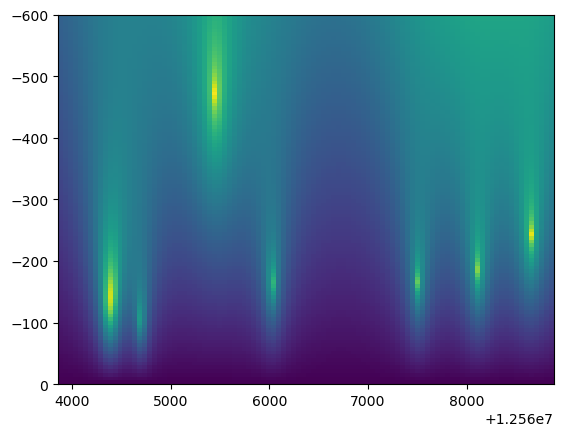

In [57]:
# Plot the initial pole landscape
fig, ax = plt.subplots()
im = ax.imshow(
    -np.log(data),
    extent=(k0_min.real, k0_max.real, 0.0, max_imag.imag),
    aspect="auto",
    vmin=0,
    vmax=6,
)

In [ ]:
# -----------------------------------------------------------------------------
# DO NOT RUN
# -----------------------------------------------------------------------------

# Get positions of poles
# NOTE: the guesses were worked out by eye from looking at the figure
# If you change Dlam or lam_centre, this needs to be modified
pole_guesses = np.array(
    [
        9.663e6 - 200j,
        9.664e6 - 200j,
        9.6645e6 - 100j,
        9.666e6 - 200j,
        9.667e6 - 150j,
        9.668e6 - 200j,
        9.6682e6 - 700j,
        9.669e6 - 100j,
        9.6695e6 - 200j,
    ]
)
poles = np.array(
    [pole_calculator.find_pole(network, guess) for guess in pole_guesses]
)

In [ ]:
# -----------------------------------------------------------------------------
# DO NOT RUN
# -----------------------------------------------------------------------------

# Save the poles
np.save(
    "/home/nbyrnes/code/networklibrary/work/ws_paper/network/data/wide_sweep/poles.npy",
    poles,
)

In [7]:
# Load the poles
poles = np.load(
    "/home/nbyrnes/code/networklibrary/work/ws_paper/network/data/wide_sweep/poles.npy"
)

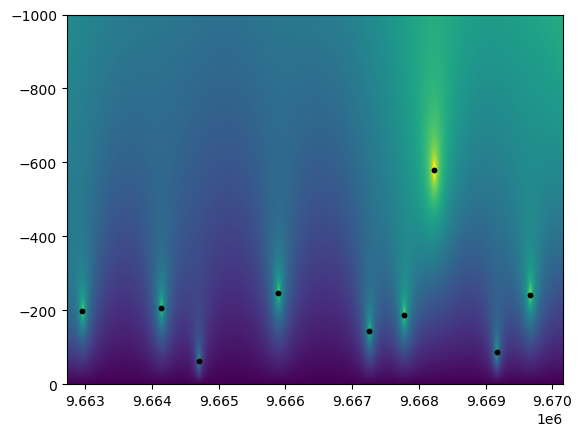

In [8]:
# Plot the initial pole landscape
plot_data = np.flip(data, axis=1)

fig, ax = plt.subplots()
im = ax.imshow(
    -np.log(data),
    extent=(k0_min.real, k0_max.real, 0.0, max_imag.imag),
    aspect="auto",
    vmin=0,
    vmax=6,
)
ax.scatter(np.real(poles), np.imag(poles), color="black", s=10)

In [9]:
# Perturbation starts here
perturbator = NetworkPerturbator(network)

link_index = 76
link_length = network.get_link(link_index).length

number_of_wavelengths = 3
required_n = number_of_wavelengths * lam_centre / link_length

print(required_n)

0.1120048901900698


In [ ]:
# -----------------------------------------------------------------------------
# DO NOT RUN
# -----------------------------------------------------------------------------

Dn_values = np.array([0.0] + np.linspace(1e-4, 1e-1, 1000))

poles_dict, pole_shifts_dict = perturbator.track_pole_segment_n(
    poles, link_index, Dn_values
)

In [ ]:
# -----------------------------------------------------------------------------
# DO NOT RUN
# -----------------------------------------------------------------------------

with open(
    "/home/nbyrnes/code/networklibrary/work/ws_paper/network/data/wide_sweep/poles_dict.pkl",
    "wb",
) as f:
    pickle.dump(poles_dict, f)
with open(
    "/home/nbyrnes/code/networklibrary/work/ws_paper/network/data/wide_sweep/pole_shifts_dict.pkl",
    "wb",
) as f:
    pickle.dump(pole_shifts_dict, f)

In [10]:
with open(
    "/home/nbyrnes/code/networklibrary/work/ws_paper/network/data/wide_sweep/poles_dict.pkl",
    "rb",
) as f:
    poles_dict = pickle.load(f)
with open(
    "/home/nbyrnes/code/networklibrary/work/ws_paper/network/data/wide_sweep/pole_shifts_dict.pkl",
    "rb",
) as f:
    poles_shifts_dict = pickle.load(f)

In [27]:
len(poles)

9

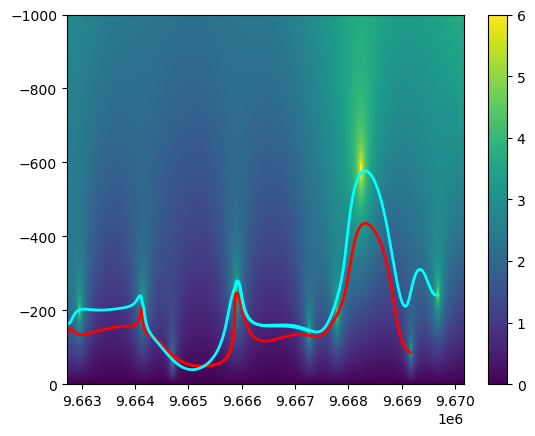

In [54]:
# Plot the initial pole landscape
plot_data = np.flip(data, axis=1)

fig, ax = plt.subplots()
im = ax.imshow(
    -np.log(data),
    extent=(k0_min.real, k0_max.real, 0.0, max_imag.imag),
    aspect="auto",
    vmin=0,
    vmax=6,
)
cbar = fig.colorbar(im)
indices = [3,7]

for line_type, color in zip(
    ["volume"], ["red"]
):
    for i, poles_list in enumerate(np.array(poles_dict[line_type])[indices]):
        xs = np.array([p.real for p in poles_list])
        ys = np.array([p.imag for p in poles_list])

        # Put a limit on the index so we only get the trajectories within the
        # plotting area
        condition = np.where(
            (xs > k0_max.real)
            | (xs < k0_min.real)
            | (ys < max_imag.imag)
            | (ys > 0.0)
        )[0]
        index = -1 if len(condition) == 0 else condition[0] + 5
        ax.plot(
            xs[:index], ys[:index], color=color, label=line_type, linewidth=2
        )

indices = [4,-1]

for line_type, color in zip(
    ["volume"], ["cyan"]
):
    for i, poles_list in enumerate(np.array(poles_dict[line_type])[indices]):
        xs = np.array([p.real for p in poles_list])
        ys = np.array([p.imag for p in poles_list])

        # Put a limit on the index so we only get the trajectories within the
        # plotting area
        condition = np.where(
            (xs > k0_max.real)
            | (xs < k0_min.real)
            | (ys < max_imag.imag)
            | (ys > 0.0)
        )[0]
        index = -1 if len(condition) == 0 else condition[0] + 5
        ax.plot(
            xs[:index], ys[:index], color=color, label=line_type, linewidth=2
        )

# ax.set_xlim(k0_min.real, 1.142e7 + 8800)
# ax.set_ylim(0, max_imag.imag)
# ax.scatter(
#     np.real(poles)[indices],
#     np.imag(poles)[indices],
#     color="white",
#     marker="x",
#     s=50,
#     zorder=3,
# )
# ax.scatter(
#     np.real(poles)[others],
#     np.imag(poles)[others],
#     color="white",
#     marker="o",
#     s=50,
#     zorder=3,
# )

# handles = [
#     plt.Line2D([], [], color=color, linestyle="-")
#     for color in ["white", "orange", "red"]
# ]
# labels = ["Direct", "External", "Internal"]
# ax.legend(
#     handles, labels, loc="upper left", framealpha=0.1, labelcolor="white"
# )
# ax.invert_xaxis()

# Set x labels as wavelengths
# lam_min = 2 * np.pi / k0_max.real
# lam_max = 2 * np.pi / k0_min.real

# graph_max = 1.142e7 + 8850
# graph_max = k0_max.real
# ax.set_xticks(
#     [
#         k0_min.real,
#         3 / 4 * k0_min.real + 1 / 4 * graph_max,
#         1 / 2 * k0_min.real + 1 / 2 * graph_max,
#         1 / 4 * k0_min.real + 3 / 4 * graph_max,
#         graph_max,
#     ]
# )
# ax.set_xticklabels(
#     [
#         f"{val / 1e-9:.1f}"
#         for val in 2
#         * np.pi
#         / np.array(
#             [
#                 k0_min.real,
#                 3 / 4 * k0_min.real + 1 / 4 * graph_max,
#                 1 / 2 * k0_min.real + 1 / 2 * graph_max,
#                 1 / 4 * k0_min.real + 3 / 4 * graph_max,
#                 graph_max,
#             ]
#         )
#     ]
# )


In [55]:
poles

array([9662956.40011995-197.49775523j, 9664136.73919315-205.49606871j,
       9664697.90436914 -63.52286859j, 9665895.32562671-246.82549268j,
       9667259.45582803-143.60930646j, 9667781.11190959-188.2881881j ,
       9668232.70930138-578.50941224j, 9669167.52756139 -85.57921969j,
       9669672.38984474-241.93155693j])

In [ ]:
# Plot the initial pole landscape
plot_data = np.flip(data, axis=1)

fig, ax = plt.subplots()
im = ax.imshow(
    -np.log(data),
    extent=(k0_min.real, k0_max.real, 0.0, max_imag.imag),
    aspect="auto",
    vmin=0,
    vmax=6,
    cmap="viridis",
)
cbar = fig.colorbar(im)

poles_direct = np.array(poles_dict["direct"])


indices = [0, 3, 4, 5, 6, 7, 10]
others = [1, 2, 8, 9]
color_one = "red"
color_two = "cyan"
marker_color = "white"
colors = [
    color_one,
    color_one,
    color_one,
    color_one,
    color_one,
    color_two,
    color_two,
]


for i, poles_list in enumerate(poles_direct[indices]):
    xs = np.array([p.real for p in poles_list])
    ys = np.array([p.imag for p in poles_list])
    color = colors[i]
    # Put a limit on the index so we only get the trajectories within the
    # plotting area
    condition = np.where(
        (xs > k0_max.real)
        | (xs < k0_min.real)
        | (ys < max_imag.imag)
        | (ys > 0.0)
    )[0]
    index = -1 if len(condition) == 0 else condition[0] + 5
    index = -1
    ax.plot(xs[:index], ys[:index], color=color, label=line_type, linewidth=2)


ax.set_xlim(k0_min.real, 1.142e7 + 8800)
ax.set_ylim(0, max_imag.imag)
ax.scatter(
    np.real(poles)[indices],
    np.imag(poles)[indices],
    color=marker_color,
    marker="x",
    s=100,
    zorder=3,
)
# ax.scatter(
#     np.real(poles)[others],
#     np.imag(poles)[others],
#     color="black",
#     marker="o",
#     s=25,
#     zorder=3,
# )

ax.invert_xaxis()

# Set x labels as wavelengths
lam_min = 2 * np.pi / k0_max.real
lam_max = 2 * np.pi / k0_min.real

graph_max = k0_max.real
ax.set_xticks(
    [
        k0_min.real,
        3 / 4 * k0_min.real + 1 / 4 * graph_max,
        1 / 2 * k0_min.real + 1 / 2 * graph_max,
        1 / 4 * k0_min.real + 3 / 4 * graph_max,
        graph_max,
    ]
)
ax.set_xticklabels(
    [
        f"{val / 1e-9:.3f}"
        for val in 2
        * np.pi
        / np.array(
            [
                k0_min.real,
                3 / 4 * k0_min.real + 1 / 4 * graph_max,
                1 / 2 * k0_min.real + 1 / 2 * graph_max,
                1 / 4 * k0_min.real + 3 / 4 * graph_max,
                graph_max,
            ]
        )
    ]
)
plt.savefig(
    "/home/nbyrnes/Code/networklibrary/work/ws_paper/network/figures/poles_direct.svg",
    format="svg",
    bbox_inches="tight",
)

In [ ]:
# Get background for zoomed in plot
# Broad sweep to find some of the poles
zoom_Dk0 = 60
zoom_k0_centre = 1.1422e7 + 250
zoom_k0_min = zoom_k0_centre - zoom_Dk0 - 180j
zoom_k0_max = zoom_k0_centre + zoom_Dk0 - 20j

num_points = 1 * 10**3
zoom_x, zoom_y, zoom_data = pole_calculator.sweep(
    zoom_k0_min, zoom_k0_max, num_points, network
)

In [ ]:
# Zoom in on the right one
# Plot the initial pole landscape
# plot_data = np.flip(data, axis=1)

fig, ax = plt.subplots()
im = ax.imshow(
    -np.log(zoom_data),
    extent=(zoom_k0_min.real, zoom_k0_max.real, -20, -180),
    aspect="auto",
    vmin=0,
    vmax=6,
)
cbar = fig.colorbar(im)
indices = [5]

# Plot shift direct
poles_formula = np.array(poles_dict["volume"])[indices][0]
xs = np.array([p.real for p in poles_formula])[:245]
ys = np.array([p.imag for p in poles_formula])[:245]
ax.plot(xs[:index], ys[:index], color="white", label=line_type, linewidth=2)

poles_direct = np.array(poles_dict["direct"])[indices][0]
xs = np.array([p.real for p in poles_direct])[:245]
ys = np.array([p.imag for p in poles_direct])[:245]
ax.plot(xs[:index], ys[:index], color="red", label=line_type, linewidth=2)


handles = [
    plt.Line2D([], [], color=color, linestyle="-")
    for color in ["red", "white"]
]
labels = ["Direct", "Wigner-Smith"]
ax.legend(
    handles, labels, loc="upper left", framealpha=0.1, labelcolor="white"
)
ax.invert_xaxis()

# Set x labels as wavelengths
lam_min = 2 * np.pi / zoom_k0_max.real
lam_max = 2 * np.pi / zoom_k0_min.real

ax.set_xticks(
    [
        zoom_k0_min.real,
        3 / 4 * zoom_k0_min.real + 1 / 4 * zoom_k0_max.real,
        1 / 2 * zoom_k0_min.real + 1 / 2 * zoom_k0_max.real,
        1 / 4 * zoom_k0_min.real + 3 / 4 * zoom_k0_max.real,
        zoom_k0_max.real,
    ]
)
ax.set_xticklabels(
    [
        f"{val / 1e-9:.3f}"
        for val in 2
        * np.pi
        / np.array(
            [
                zoom_k0_min.real,
                3 / 4 * zoom_k0_min.real + 1 / 4 * zoom_k0_max.real,
                1 / 2 * zoom_k0_min.real + 1 / 2 * zoom_k0_max.real,
                1 / 4 * zoom_k0_min.real + 3 / 4 * zoom_k0_max.real,
                zoom_k0_max.real,
            ]
        )
    ]
)

ax.scatter(
    np.real(poles)[indices],
    np.imag(poles)[indices],
    color="white",
    marker="x",
    s=200,
    zorder=3,
)
plt.savefig(
    "/home/nbyrnes/Code/networklibrary/work/ws_paper/network/figures/poles_zoom_one.svg",
    format="svg",
    bbox_inches="tight",
)

In [ ]:
# Get background for zoomed in plot
# Broad sweep to find some of the poles
zoom_Dk0_2 = 750
zoom_k0_centre_2 = 1.142e7 + 6000
zoom_k0_min_2 = zoom_k0_centre_2 - zoom_Dk0_2 - 250j
zoom_k0_max_2 = zoom_k0_centre_2 + zoom_Dk0_2 - 50j

num_points = 1 * 10**3
zoom_x_2, zoom_y_2, zoom_data_2 = pole_calculator.sweep(
    zoom_k0_min_2, zoom_k0_max_2, num_points, network
)

In [ ]:
# Zoom in on the right one
# Plot the initial pole landscape
# plot_data = np.flip(data, axis=1)

fig, ax = plt.subplots()
im = ax.imshow(
    -np.log(zoom_data_2),
    extent=(zoom_k0_min_2.real, zoom_k0_max_2.real, -50, -250),
    aspect="auto",
    vmin=0,
    vmax=6,
)
ax.set_xlim(zoom_k0_min_2.real, zoom_k0_max_2.real)
ax.set_ylim(-50, -250)

cbar = fig.colorbar(im)
indices = [3, 7]
poles_direct = np.array(poles_dict["direct"])
poles_volume = np.array(poles_dict["volume"])


for i, poles_list in enumerate(poles_volume[indices]):
    xs = np.array([p.real for p in poles_list])
    ys = np.array([p.imag for p in poles_list])
    color = colors[i]
    # Put a limit on the index so we only get the trajectories within the
    # plotting area
    index = -1
    ax.plot(xs[:index], ys[:index], color="white", linewidth=2)

for i, poles_list in enumerate(poles_direct[indices]):
    xs = np.array([p.real for p in poles_list])
    ys = np.array([p.imag for p in poles_list])
    color = colors[i]
    # Put a limit on the index so we only get the trajectories within the
    # plotting area
    index = -1
    ax.plot(xs[:index], ys[:index], color="red", linewidth=2)

handles = [
    plt.Line2D([], [], color=color, linestyle="-")
    for color in ["red", "white"]
]
labels = ["Direct", "Wigner-Smith"]
ax.legend(
    handles, labels, loc="lower left", framealpha=0.1, labelcolor="white"
)
ax.invert_xaxis()

# Set x labels as wavelengths
lam_min = 2 * np.pi / zoom_k0_max_2.real
lam_max = 2 * np.pi / zoom_k0_min_2.real

ax.set_xticks(
    [
        zoom_k0_min_2.real,
        3 / 4 * zoom_k0_min_2.real + 1 / 4 * zoom_k0_max_2.real,
        1 / 2 * zoom_k0_min_2.real + 1 / 2 * zoom_k0_max_2.real,
        1 / 4 * zoom_k0_min_2.real + 3 / 4 * zoom_k0_max_2.real,
        zoom_k0_max_2.real,
    ]
)
ax.set_xticklabels(
    [
        f"{val / 1e-9:.3f}"
        for val in 2
        * np.pi
        / np.array(
            [
                zoom_k0_min_2.real,
                3 / 4 * zoom_k0_min_2.real + 1 / 4 * zoom_k0_max_2.real,
                1 / 2 * zoom_k0_min_2.real + 1 / 2 * zoom_k0_max_2.real,
                1 / 4 * zoom_k0_min_2.real + 3 / 4 * zoom_k0_max_2.real,
                zoom_k0_max_2.real,
            ]
        )
    ]
)

ax.scatter(
    np.real(poles)[indices],
    np.imag(poles)[indices],
    color=marker_color,
    marker="x",
    s=200,
    zorder=3,
)

plt.savefig(
    "/home/nbyrnes/Code/networklibrary/work/ws_paper/network/figures/poles_zoom_two.svg",
    format="svg",
    bbox_inches="tight",
)

In [ ]:
# Get background for zoomed in plot
# Broad sweep to find some of the poles
zoom_Dk0_3 = 750
zoom_k0_centre_3 = 1.142e7 + 4000
zoom_k0_min_3 = zoom_k0_centre_3 - zoom_Dk0_3 - 850j
zoom_k0_max_3 = zoom_k0_centre_3 + zoom_Dk0_3 - 650j

num_points = 1 * 10**3
zoom_x_3, zoom_y_3, zoom_data_3 = pole_calculator.sweep(
    zoom_k0_min_3, zoom_k0_max_3, num_points, network
)

In [ ]:
# Zoom in on the right one
# Plot the initial pole landscape
# plot_data = np.flip(data, axis=1)

fig, ax = plt.subplots()
im = ax.imshow(
    -np.log(zoom_data_3),
    extent=(zoom_k0_min_3.real, zoom_k0_max_3.real, -650, -850),
    aspect="auto",
    vmin=0,
    vmax=8,
)
ax.set_xlim(zoom_k0_min_3.real, zoom_k0_max_3.real)
ax.set_ylim(-650, -850)

cbar = fig.colorbar(im)
indices = [3]
poles_direct = np.array(poles_dict["direct"])
poles_volume = np.array(poles_dict["volume"])


for i, poles_list in enumerate(poles_volume[indices]):
    xs = np.array([p.real for p in poles_list])
    ys = np.array([p.imag for p in poles_list])
    color = colors[i]
    # Put a limit on the index so we only get the trajectories within the
    # plotting area
    index = -1
    ax.plot(xs[:index], ys[:index], color="white", linewidth=2)
for i, poles_list in enumerate(poles_direct[indices]):
    xs = np.array([p.real for p in poles_list])
    ys = np.array([p.imag for p in poles_list])
    color = colors[i]
    # Put a limit on the index so we only get the trajectories within the
    # plotting area
    index = -1
    ax.plot(xs[:index], ys[:index], color="red", linewidth=2)


handles = [
    plt.Line2D([], [], color=color, linestyle="-")
    for color in ["red", "white"]
]
labels = ["Direct", "Wigner-Smith"]
ax.legend(
    handles, labels, loc="upper left", framealpha=0.1, labelcolor="white"
)
ax.invert_xaxis()

# # Set x labels as wavelengths
lam_min = 2 * np.pi / zoom_k0_max_3.real
lam_max = 2 * np.pi / zoom_k0_min_3.real

ax.set_xticks(
    [
        zoom_k0_min_3.real,
        3 / 4 * zoom_k0_min_3.real + 1 / 4 * zoom_k0_max_3.real,
        1 / 2 * zoom_k0_min_3.real + 1 / 2 * zoom_k0_max_3.real,
        1 / 4 * zoom_k0_min_3.real + 3 / 4 * zoom_k0_max_3.real,
        zoom_k0_max_3.real,
    ]
)
ax.set_xticklabels(
    [
        f"{val / 1e-9:.3f}"
        for val in 2
        * np.pi
        / np.array(
            [
                zoom_k0_min_3.real,
                3 / 4 * zoom_k0_min_3.real + 1 / 4 * zoom_k0_max_3.real,
                1 / 2 * zoom_k0_min_3.real + 1 / 2 * zoom_k0_max_3.real,
                1 / 4 * zoom_k0_min_3.real + 3 / 4 * zoom_k0_max_3.real,
                zoom_k0_max_3.real,
            ]
        )
    ]
)
plt.savefig(
    "/home/nbyrnes/Code/networklibrary/work/ws_paper/network/figures/poles_zoom_three.svg",
    format="svg",
    bbox_inches="tight",
)
# ax.scatter(
#     np.real(poles)[indices],
#     np.imag(poles)[indices],
#     color=marker_color,
#     marker="x",
#     s=100,
#     zorder=3,
# )

In [ ]:
# Get background for zoomed in plot
# Broad sweep to find some of the poles
zoom_Dk0_4 = 700
zoom_k0_centre_4 = 1.142e7 + 8300
zoom_k0_min_4 = zoom_k0_centre_4 - zoom_Dk0_4 - 300j
zoom_k0_max_4 = zoom_k0_centre_4 + zoom_Dk0_4 - 100j

num_points = 1 * 10**3
zoom_x_4, zoom_y_4, zoom_data_4 = pole_calculator.sweep(
    zoom_k0_min_4, zoom_k0_max_4, num_points, network
)

In [ ]:
# Zoom in on the right one
# Plot the initial pole landscape
# plot_data = np.flip(data, axis=1)

fig, ax = plt.subplots()
im = ax.imshow(
    -np.log(zoom_data_4),
    extent=(zoom_k0_min_4.real, zoom_k0_max_4.real, -100, -300),
    aspect="auto",
    vmin=0,
    vmax=6,
)
ax.set_xlim(zoom_k0_min_4.real, zoom_k0_max_4.real)
ax.set_ylim(-100, -300)

cbar = fig.colorbar(im)
indices = [3, 10]
poles_direct = np.array(poles_dict["direct"])
poles_volume = np.array(poles_dict["volume"])

for i, poles_list in enumerate(poles_volume[indices]):
    xs = np.array([p.real for p in poles_list])
    ys = np.array([p.imag for p in poles_list])
    color = colors[i]
    # Put a limit on the index so we only get the trajectories within the
    # plotting area
    index = -1
    ax.plot(xs[:index], ys[:index], color="white", linewidth=2)


for i, poles_list in enumerate(poles_direct[indices]):
    xs = np.array([p.real for p in poles_list])
    ys = np.array([p.imag for p in poles_list])
    color = ["red", "cyan"][i]
    # Put a limit on the index so we only get the trajectories within the
    # plotting area
    index = -1
    ax.plot(xs[:index], ys[:index], color=color, linewidth=2)


handles = [
    plt.Line2D([], [], color=color, linestyle="-")
    for color in ["red", "white"]
]
labels = ["Direct", "Wigner-Smith"]
ax.legend(
    handles, labels, loc="lower left", framealpha=0.1, labelcolor="white"
)
ax.invert_xaxis()
ax.scatter(
    np.real(poles)[10],
    np.imag(poles)[10],
    color=marker_color,
    marker="x",
    s=200,
    zorder=3,
)

# # # Set x labels as wavelengths
lam_min = 2 * np.pi / zoom_k0_max_4.real
lam_max = 2 * np.pi / zoom_k0_min_4.real

ax.set_xticks(
    [
        zoom_k0_min_4.real,
        3 / 4 * zoom_k0_min_4.real + 1 / 4 * zoom_k0_max_4.real,
        1 / 2 * zoom_k0_min_4.real + 1 / 2 * zoom_k0_max_4.real,
        1 / 4 * zoom_k0_min_4.real + 3 / 4 * zoom_k0_max_4.real,
        zoom_k0_max_4.real,
    ]
)
ax.set_xticklabels(
    [
        f"{val / 1e-9:.3f}"
        for val in 2
        * np.pi
        / np.array(
            [
                zoom_k0_min_4.real,
                3 / 4 * zoom_k0_min_4.real + 1 / 4 * zoom_k0_max_4.real,
                1 / 2 * zoom_k0_min_4.real + 1 / 2 * zoom_k0_max_4.real,
                1 / 4 * zoom_k0_min_4.real + 3 / 4 * zoom_k0_max_4.real,
                zoom_k0_max_4.real,
            ]
        )
    ]
)
plt.savefig(
    "/home/nbyrnes/Code/networklibrary/work/ws_paper/network/figures/poles_zoom_four.svg",
    format="svg",
    bbox_inches="tight",
)

In [ ]:
network.draw()